In [27]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from scipy import sparse
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb



train=pd.read_csv(r"C:\Users\yjhut\OneDrive\바탕 화면\데이콘 제주시 공모전 csv 파일\train.csv")
test=pd.read_csv(r"C:\Users\yjhut\OneDrive\바탕 화면\데이콘 제주시 공모전 csv 파일\test.csv")
sample_submission=pd.read_csv(r"C:\Users\yjhut\OneDrive\바탕 화면\데이콘 제주시 공모전 csv 파일\sample_submission.csv")

In [3]:
pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas


In [5]:
pandas.__version__

'2.0.3'

In [28]:
def resumtable(df):
  print( f'데이터 형상: ',{df.shape})
  summary=pd.DataFrame(df.dtypes,columns=['데이터 타입'])
  summary=summary.reset_index()
  summary=summary.rename(columns={'index':'피처'})
  summary['결측값 개수']=df.isnull().sum().values
  summary['고유값 개수']=df.nunique().values
  summary['첫 번째 값']=df.loc[0].values
  summary['두 번째 값']=df.loc[1].values
  summary['세 번째 값']=df.loc[2].values

  return summary

In [29]:
resumtable(train)

데이터 형상:  {(4701217, 23)}


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값,세 번째 값
0,id,object,0,4701217,TRAIN_0000000,TRAIN_0000001,TRAIN_0000002
1,base_date,int64,0,281,20220623,20220728,20211010
2,day_of_week,object,0,7,목,목,일
3,base_hour,int64,0,24,17,21,7
4,lane_count,int64,0,3,1,2,2
5,road_rating,int64,0,3,106,103,103
6,road_name,object,0,61,지방도1112호선,일반국도11호선,일반국도16호선
7,multi_linked,int64,0,2,0,0,0
8,connect_code,int64,0,2,0,0,0
9,maximum_speed_limit,float64,0,6,60.0,60.0,80.0


In [30]:
# 벡터화는 road_name /  start_node_name  / end_node_name / start_turn_restricted / end_turn_restricted  / day_of_week을 진행

In [31]:
#원본 데이터에서 삭제하려는 col중에 target 값과 상관관계가 더 높은 변수를 남겨둔다.

In [32]:
resumtable(test)

데이터 형상:  {(291241, 22)}


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값,세 번째 값
0,id,object,0,291241,TEST_000000,TEST_000001,TEST_000002
1,base_date,int64,0,31,20220825,20220809,20220805
2,day_of_week,object,0,7,목,화,금
3,base_hour,int64,0,24,17,12,2
4,lane_count,int64,0,3,3,2,1
5,road_rating,int64,0,3,107,103,103
6,road_name,object,0,46,연삼로,일반국도12호선,일반국도16호선
7,multi_linked,int64,0,1,0,0,0
8,connect_code,int64,0,1,0,0,0
9,maximum_speed_limit,float64,0,5,70.0,70.0,60.0


In [33]:
all_data=pd.concat([train,test])
all_data=all_data.drop('target',axis=1)
all_data.shape

(4992458, 22)

In [34]:
all_data=all_data.set_index('id')

In [35]:
all_data['day_of_week']=all_data['day_of_week'].map({'일':0,'월':1,'화':2,'수':3,'목':4,'금':5,'토':6})
# 범주형 변수 인코딩 

In [36]:
from sklearn.preprocessing import OneHotEncoder

oh_encode=OneHotEncoder()

encoded_road_matrix=oh_encode.fit_transform(all_data[['road_name']])

all_data=all_data.drop('road_name',axis=1)

encoded_road_matrix

#효율, 연산시간 save 위해  -> CSR 형식



<4992458x61 sparse matrix of type '<class 'numpy.float64'>'
	with 4992458 stored elements in Compressed Sparse Row format>

In [37]:
encoded_end_matrix=oh_encode.fit_transform(all_data[['end_node_name']])
all_data=all_data.drop('end_node_name',axis=1)


encoded_end_matrix

# 변환할 범주형 뱐수들 모두 csr_matrix 형태로 인코딩

<4992458x487 sparse matrix of type '<class 'numpy.float64'>'
	with 4992458 stored elements in Compressed Sparse Row format>

In [38]:
encoded_start_matrix=oh_encode.fit_transform(all_data[['start_node_name']])
all_data=all_data.drop('start_node_name',axis=1)

encoded_start_matrix

# 변환할 범주형 뱐수들 모두 csr_matrix 형태로 인코딩

<4992458x487 sparse matrix of type '<class 'numpy.float64'>'
	with 4992458 stored elements in Compressed Sparse Row format>

In [40]:
all_data['start_turn_restricted']=all_data['start_turn_restricted'].map({'있음':1,'없음':0})
all_data['end_turn_restricted']=all_data['end_turn_restricted'].map({'있음':1,'없음':0})

# start_turn_restricted , end_turn_restricted는 map 함수로 진행 

In [41]:
all_data.describe()

,base_date,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
count,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4992458.0,4.992458e+06,4992458.0,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06,4.992458e+06
mean,2.021696e+07,3.003807e+00,1.192403e+01,1.847427e+00,1.049753e+02,4.484765e-04,2.505031e-01,6.110851e+01,0.0,5.504004e+03,0.0,6.163683e-01,3.338299e+01,1.265212e+02,1.013106e-01,3.338300e+01,1.265212e+02,1.013341e-01
std,4.523985e+03,1.996626e+00,6.726881e+00,6.929471e-01,1.842662e+00,2.117252e-02,5.073369e+00,1.210544e+01,0.0,1.382166e+04,0.0,1.212104e+00,1.022663e-01,1.524749e-01,3.017396e-01,1.022600e-01,1.524585e-01,3.017706e-01
min,2.021090e+07,0.000000e+00,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,0.000000e+00,3.324343e+01,1.261826e+02,0.000000e+00
25%,2.021120e+07,1.000000e+00,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326269e+01,1.264244e+02,0.000000e+00,3.326269e+01,1.264244e+02,0.000000e+00
50%,2.022020e+07,3.000000e+00,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341209e+01,1.265112e+02,0.000000e+00,3.341209e+01,1.265112e+02,0.000000e+00
75%,2.022052e+07,5.000000e+00,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347860e+01,1.265780e+02,0.000000e+00,3.347860e+01,1.265780e+02,0.000000e+00
max,2.022083e+07,6.000000e+00,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,1.000000e+00,3.355608e+01,1.269309e+02,1.000000e+00


In [42]:
from sklearn.preprocessing import StandardScaler

s_scaler=StandardScaler()
all_data[['weight_restricted']]=s_scaler.fit_transform(all_data[['weight_restricted']])

In [43]:
all_data=all_data.drop('connect_code',axis=1)
all_data=all_data.drop('multi_linked',axis=1)
all_data=all_data.drop('day_of_week',axis=1)

In [44]:
all_data_sprs2=sparse.hstack([sparse.csr_matrix(all_data),
                            encoded_end_matrix,
                            encoded_start_matrix,
                            encoded_road_matrix],
                            format='csr')

# 이전 모든 결과 하나의 matrix로 생성

In [45]:
all_data_sprs2

<4992458x1050 sparse matrix of type '<class 'numpy.float64'>'
	with 66773732 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.model_selection import train_test_split

num_train=len(train)

X_train=all_data_sprs2[:num_train]
X_test=all_data_sprs2[num_train:]

y=train['target']

X_tr,X_val,y_tr,y_val=train_test_split(X_train,y,
                                      test_size=0.2,
                                      random_state=43)


In [47]:
lgbr_model=lgb.LGBMRegressor(random_state=43, learning_rate=0.1, num_iterations=5000 ,max_depth=12, boosting_type='goss')
                                                                 
lgbr_model.fit(X_tr,y_tr)

lgb_preds=lgbr_model.predict(X_val)

print(f'lgbr모델의 MAE 값:  {mean_absolute_error(y_val,lgb_preds):.4f}')

# LGBMRgressor 모델의 MAE 값:  3.0808  goss  학습률:0.1   depth=10
# LGBMRgressor 모델의 MAE 값:  3.1926  goss  학습률:0.05  depth=8
# LGBMRgressor 모델의 MAE 값:  3.1796  goss  학습률:0.05  depth=10


#  gbr모델의 MAE 값:  3.1426   gbdt


#lgbr모델의 MAE 값:   3.0771    test_size= 0.2 나머지는 맨 윗줄과 동일하게 진행

#lgbr모델의 MAE 값:   3.0790    test_size=0.25로 놓고 나머지는 바로 윗줄과 동일하게 진행

#lgbr모델의 MAE 값:    3.0796    w.r를 frobustscaler가 아닌 제거하고 진행

# 3.0606

#lgbr모델의 MAE 값:  3.0560  max_depth=11

#lgbr모델의 MAE 값:  3.0538  max_depth=12

#lgbr모델의 MAE 값:  3.0579  test_size=0.25로 하니까 오히려 오차가 증가함  max_depth=12 그대로 했음 

lgbr모델의 MAE 값:  3.1084


In [56]:
lgbr_model2=lgb.LGBMRegressor(random_state=43)
ddff=all_data[:num_train]
pred3=lgbr_model2.fit(ddff,y)




<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

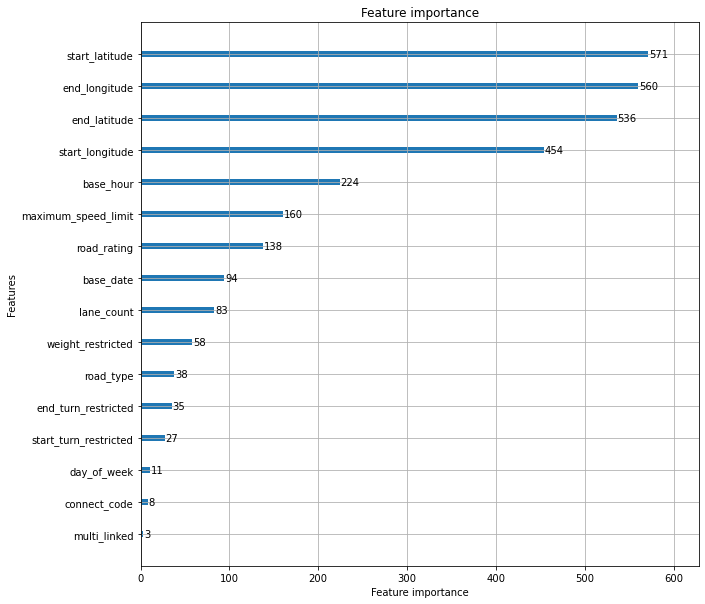

In [57]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(10,10))
plot_importance(lgbr_model2,ax=ax)

In [ ]:
lgbr_preds2=lgbr_model.predict(X_test)

In [ ]:
sample_submission['target']=lgbr_preds2

In [ ]:
sample_submission.to_csv('submission_sample1101(1).csv',index=False)

In [ ]:
# all_data=all_data.drop(['vehicle_restricted','height_restricted'],axis=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid={'learning_rate':[0.1,0.05], 'max_depth':[10]}

lgb_grid_model=GridSearchCV(estimator=lgb.LGBMRegressor(random_state=43, 
                                                        num_iterations=5000 , 
                                                        boosting_type='goss'),
                             param_grid=param_grid,
                             cv=2)

lgb_grid_model.fit(X_tr,y_tr)
print(lgb_grid_model.best_params_)

lgb_grid_model_preds=lgb_grid_model.best_params_.predict(X_val)

print(f'lgb + gridS의  MAE값: {mean_absolute_error(y_val,lgb_grid_model_preds):.4f}')

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param={
#     'max_depth':[6,7,8,9,10],
#     'num_iterations':[3000,4000,5000],
#     'random_state':[43],
#     'learning_rate':[0.01,0.05,0.25,0.1]
# }

# n_iter=30

# # lgbr_model=lgb.LGBMRegressor(random_state=43, learning_rate=0.1, num_iterations=5000 ,max_depth=8, boosting_type='goss')

# lgb_random_model=RandomizedSearchCV(estimator=lgb.LGBMRegressor(),
#                                 param_distributions=param,
#                                 cv=5,
#                                 n_iter=n_iter)


# lgb_random_model.fit(X_tr,y_tr)

# print(lgb_random_model.best_params_)

# random_model_preds=lgb_random_model.best_params_.predict(X_val)

# print(f'lgb + 랜덤서치 MAE값: {mean_absolute_error(y_val,random_model_preds):.4f}')

